In [ ]:
import numpy as np
import scipy.stats as si
from pricing_models import Black_Scholes, LVM
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
tfb = tfp.bijectors
from gp_models import CustomKernel,GP_model, GPR_model, GPR_analytical
from vol_surfaces import Smile,SVI,SSVI

In [ ]:
# Define the training data set

# Shape and range of time to maturity, strike
n_stocks = 10
n_taus = 4
K_min = 70
K_max = 130
tau_min = 0.1
tau_max = 0.4

strikes=np.tile(np.linspace(K_min,K_max,n_stocks),n_taus)
tau = np.repeat(np.linspace(tau_min,tau_max,n_taus),n_stocks)
X_base = np.array([tau,strikes]).T

# Parameters for default SVI parametrisation
plot_strikes = np.linspace(75,150,40)
a_0 = 0.04
b_0 = 0.4
rho_0 = -0.4
m_0 = 0
sigma_0 = 0.1

# List of different values for each parameters to 
# generate different training data volatility surfaces
b_list = [0.1,0.5,1,2]
rho_list=[0.3,0,-0.3,-0.6]
sigma_list = [0.1,0.2,0.3,0.4]
m_list = [-0.2,-0.1,0,0.1]
a_list = [0.1,0.2,0.4,0.6]

y = np.array([])
kvars = np.array([])

# Same lists but for SSVI case
eta_list = [1,2,5,10]
l_list = [0.15,0.3,0.45,0.6]

for rho_ in rho_list:
    # a is always updated to keep the y-coordinate of the kink stable
    
    #a_i = a_0 + sigma_0*np.sqrt(1-rho_0**2)*(b_0-b_)
    a_i = a_0 + sigma_0*b_0*(np.sqrt(1-rho_0**2)-np.sqrt(1-rho_**2))
    #a_i = a_0 + b_0*np.sqrt(1-rho_0**2)*(sigma_0-sigma_)
    
    #m_i = -rho_0/(np.sqrt(1-rho_0**2))*(sigma_0-sigma_)

    # Define volatility surface with given parameters
    
    smile = SVI(a=a_i,rho=rho_)
    #smile=SSVI(eta=5,lamb=lamb_)
    
    # Generate prices
    y_i = smile.call(100,X_base[:,0],X_base[:,1])
    
    # Compute the variance strike for this surface
    kvar_i = smile.K_var(N=100,bound=50,T=[1])*np.ones(n_stocks*n_taus)
    y = np.concatenate([y,y_i])
    kvars = np.concatenate([kvars,kvar_i])
    
    # Plot the surface slice
    surf = smile.sigma(0.3,plot_strikes)
    plt.plot(plot_strikes,surf,'--',label = r'$\sigma = $'+str(sigma_))

# Generate the test slices in order to plot everything together    

#Parameters for 1st test slice: select the relevant test parameter
m_test = 0.05
a_test = 0.5
b_test = 1.5
rho_test = -0.15
sigma_test = 0.15

a_test = a_0 + sigma_0*b_0*(np.sqrt(1-rho_0**2)-np.sqrt(1-rho_test**2))
# a_test = a_0 + b_0*np.sqrt(1-rho_0**2)*(sigma_0-sigma_test)
# a_test = a_0 + sigma_0*np.sqrt(1-rho_0**2)*(b_0-b_test)

#m_test = -rho_0/np.sqrt(1-rho_0**2)*(sigma_0-sigma_test)

svi_test = SVI(a=a_test,rho=rho_test)
#svi_test = SVI(m=m_test)
surf1 = svi_test.sigma(0.3,plot_strikes)


# Parameters for 2nd test surface: select the relevant test parameter
rho_test = -0.8
b_test = 2.5
sigma_test = 0.05
m_test = 0.2
a_test=0.8

# a_test = a_0 + sigma_0*np.sqrt(1-rho_0**2)*(b_0-b_test)
a_test = a_0 + sigma_0*b_0*(np.sqrt(1-rho_0**2)-np.sqrt(1-rho_test**2))
# a_test = a_0 + b_0*np.sqrt(1-rho_0**2)*(sigma_0-sigma_test)

m_test = -rho_0/np.sqrt(1-rho_0**2)*(sigma_0-sigma_test)

svi_test = SVI(a=a_test,rho=rho_test)
#svi_test =SVI(m=m_test)
surf2= svi_test.sigma(0.3,plot_strikes)

plt.plot(plot_strikes,surf1,':',label = r'$\sigma^*_{1}= 0.15$',c= 'black')
plt.plot(plot_strikes,surf2,':',label = r'$\sigma^*_{2}= 0.05$',c= 'black')

plt.xlabel('Strike')
plt.ylabel(r'$\sigma(K,\tau = 0.3)$')
plt.legend()
path = '/Users/danielmontagna/Documents/ETHZ/PH-MA3/Thesis/Report/thesis/Figures/SVI/'
path+= 'changing_sigma_vol.pdf'
#plt.savefig(path)
    
include_swap = True

X_noswap = np.tile(X_base,(len(m_list),1))

X = np.concatenate([X_noswap,np.reshape(kvars,[-1,1])],axis=1)

if not include_swap: X = X[:,:2]
print(X.shape)

Text(0.5, 0.92, '$\\lambda = 0.3, \\eta=5, \\rho= -0.4$')

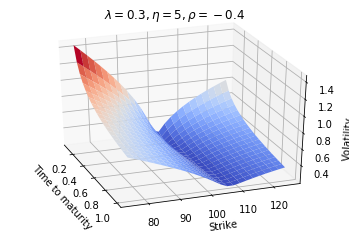

In [19]:
# 3D plot of implied volatility surfacee

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
smile=SVI()
smile=SSVI(lamb=0.7,eta=5,rho=-0.4)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
XX,YY = np.meshgrid(tau[:40:10],(strikes[:10]))
XX,YY = np.meshgrid(np.linspace(0.1,1,20),np.linspace(75,125,25))
#ZZ = IVs.reshape(XX.shape)
ZZ=smile.sigma(np.ravel(XX),np.ravel(YY)).reshape(XX.shape)

#ZZ = price_model.sigma(0.4-np.ravel(YY),np.ravel(XX),50).reshape(XX.shape)
ax.plot_surface(XX,YY,ZZ,cmap = cm.coolwarm)
ax.set_ylabel('Strike')
ax.set_xlabel('Time to maturity')
ax.set_zlabel('Volatility')
ax.view_init(30, -20)
plt.title(r'$\lambda = 0.3, \eta=5, \rho= -0.4$')
#fig.tight_layout()
#plt.savefig('/Users/danielmontagna/Documents/ETHZ/PH-MA3/Thesis/Report/thesis/Figures/SVI/ssvi_vol.pdf')

In [ ]:
#Define trainable variables

#Mean function variables
b0 = tf.Variable(0,dtype=tf.float64, name = 'b0')
b1 = tf.Variable([1],dtype=tf.float64, name= 'b1')
b2 = tf.Variable([0],dtype=tf.float64, name= 'b2')
#Kernel variables
process_variance = 50
noise_variance = 0.0001
length_scales =[0.5,20]
lower_bounds = [0.01,10]
upper_bounds = [5,100]
trend_coef = [[1,1]]
if include_swap:
    lower_bounds.append(0.0001)
    upper_bounds.append(2.)
    length_scales.append(0.1)
    
    trend_coef[0].append(1)

b = tf.Variable(trend_coef,dtype=tf.float64, name= 'b')

sp = tfp.util.TransformedVariable(process_variance, tfb.Exp(), dtype=tf.float64, name='sigma_process')
sn2 = tfp.util.TransformedVariable(noise_variance, tfb.Exp(), dtype=tf.float64, name='sigma_noise2')
scales = tf.Variable(length_scales,constraint = lambda x: tf.clip_by_value(x,lower_bounds,upper_bounds),dtype=tf.float64, name = 'length_scales')

#Define custom kernel
kernel_family = 'M52'
param ={'amp' : sp , 'scales': scales,'family' : kernel_family}


kernel_family = 'M52'
param = {'amp' : sp , 'scales': scales,'family' : kernel_family}
my_kernel = CustomKernel(1,parameters = param)
#Define mean function
def mean_f(x): return b0 + b2*x[:,1] # + b1*x[:,0]
#def mean_f(x): return 0

In [ ]:
#Define and fit the model
GP = GP_model(my_kernel, index_points=X,mean_fn=mean_f, beta=(b2,b0),observation_noise_variance=sn2,jitter=1e-06, name='GP')
GP.fit(y,n_iters=1200,verbose=True,optimizer = tf.optimizers.Adam(0.1))
print('\n## Trained Hyperparameters ##\n')
print(b0,b2)
print(sp)
print(scales)
print(sn2)
#print(slope,bias,shift)
#GP.hyperparam

In [ ]:
# Define volatility surface for test set
# Case b
b_test = 2.5 # 1.5
a_test = a_0 + sigma_0*np.sqrt(1-rho_0**2)*(b_0-b_test)
smile_test=SVI(a=a_test,b=b_test)

# Case rho
rho_test = -0.15 # -0.8
a_test = a_0 + sigma_0*b_0*(np.sqrt(1-rho_0**2)-np.sqrt(1-rho_test**2))
smile_test=SVI(a=a_test,rho=rho_test)

#Case sigma
sigma_test = 0.05
a_test = a_0 + b_0*np.sqrt(1-rho_0**2)*(sigma_0-sigma_test)
m_test = -rho_0/np.sqrt(1-rho_0**2)*(sigma_0-sigma_test)
smile_test=SVI(m=m_test,a=a_test,sigma0=sigma_test)
# Case m
m_test = 0.05 # 0.2
smile_test = SVI(m = m_test)

# Case eta
eta_test = 7.5 # 12.5
smile_test = SSVI(eta=eta_test,lamb=0.3)

# Case lambda
l_test = 0.5 # 0.7
smile_test = SSVI(eta=5,lamb=l_test)


n_test_points = 50
K_min = 60
K_max = 140
tau_test = 0.25 * np.ones(n_test_points)
strike_test = np.linspace(K_min,K_max,n_test_points)
X_test = np.array([tau_test,strike_test]).T

if include_swap:
    kvar_test = np.ones(len(tau_test))*smile_test.K_var(T=[0.3],N=100,bound=50)
    X_test = np.concatenate([X_test,np.reshape(kvar_test,[-1,1])],axis=1)
    
    
y_test = smile_test.call(100,X_test[:,0],X_test[:,1])

In [ ]:
#Define a GP Regression model with learned parameters
GPR = GPR_model(my_kernel,X_test,X,y,observation_noise_variance=sn2,predictive_noise_variance=None,mean_fn=mean_f,jitter=1e-6)

In [ ]:
# Plot predictions, confidence bounds and the underlying truee model prices

fig_path = '/Users/danielmontagna/Documents/ETHZ/PH-MA3/Thesis/Report/thesis/Figures/SVI/'
fig_name = 'changing_sigma2_tau025.pdf'
fig_path += fig_name
GPR.plot_price(y_test,x_values=X_test[:,1],title=False)#,fig_name = fig_path)


In [ ]:
# RMSE error computation for 1 test slice

from sklearn.metrics import mean_squared_error as mse

y_e = y_test[9:41]
pred_e = GPR.mean()[9:41]
var = np.mean(GPR.variance()[9:41])
err = mse(y_e,pred_e)

print('rmse (inter) = ' ,np.sqrt(err))
print('var (inter) = ',var)

err = mse(y_test,GPR.mean())
var = np.mean(GPR.variance())

print('rmse = ' ,np.sqrt(err))
print('var = ',var)

In [ ]:
# Compute average error over the entire surface by considering 20 slices

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.metrics import mean_squared_error as mse
ttest = np.linspace(0.1,1,20)
ktest = np.linspace(70,130,61)
TT,KK = np.meshgrid(ttest,ktest)
Xtest = np.array([np.ravel(TT),np.ravel(KK),np.ones(2*610)*smile_test.K_var(N=100,bound=50)]).T
Xtest = np.array([np.ravel(TT),np.ravel(KK)]).T
the_GPR = GPR_model(my_kernel,Xtest,X,y,observation_noise_variance=sn2,predictive_noise_variance=None,mean_fn=mean_f,jitter=1e-6)

pred = the_GPR.price()
prices = smile_test.call(100,np.ravel(TT),np.ravel(KK))

print(mse(pred,prices),np.sqrt(mse(pred,prices)))